In [31]:
import sys
sys.path.insert(0, '../')

from fuzzywuzzy import process
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
from pytesseract import Output, TesseractError
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
import spacy
from tqdm.auto import tqdm
import torch

from src.features import build_features

In [32]:
rvlcdip_path = "./../data/raw/selected"

#puting all the files, pictures and targets into a list
picture_list = []
target_list = []
file_list = []

for file in glob.glob(f"{rvlcdip_path}/*.tif")[:20]:
    try:
        with Image.open(file) as img:
            img_array = np.array(img) #save to a numpy array because there was too much files open otherwise.
            picture_list.append(img_array)

        target_file = file.replace(".tif", ".txt")
        with open(target_file, 'r', encoding='utf-8') as f:
            target = f.read()
            target_list.append(target)
            file_list.append(file.split('\\')[-1])
    except UnidentifiedImageError:
        print(f"Le fichier {file} n'a pas pu être ouvert.")
        continue

#stitching in a dataframe file name, picture and text
df = pd.DataFrame(columns=['filename', 'picture', 'target'])
df['filename'] = file_list
df['picture'] = picture_list
df['target'] = target_list
df['target'] = df['target'].astype(int)

In [33]:
#function to ocr the pictures with pytesseract
def ocr_pytesseract(pic_series):
    ocr_text_tess_list = []
    for img_array in tqdm(pic_series):
        #transform the numpy array to a picture
        pic = Image.fromarray(img_array)
        ocr_text_tess = pytesseract.image_to_string(pic, config='--psm 3')
        ocr_text_tess = re.sub(r'\n', ' ', ocr_text_tess)
        ocr_text_tess_list.append(ocr_text_tess)

    return ocr_text_tess_list

In [34]:
#function to clean the texts
def clean_text(text):
    clean_text_list = []
    for text in tqdm(text):
        clean_text_list.append(build_features.text_cleaning(text))
    return clean_text_list

In [35]:
#function to calculate the text orientation
def get_text_orientation(image):
    try:
        data = pytesseract.image_to_osd(image, output_type=Output.DICT)
        rotate_angle = data['rotate']
        return rotate_angle
    except TesseractError:
        rotate_angle = 0
        return rotate_angle

In [36]:
#function to rotate the image
def rotate_image(img_array, angle):
    #only if angle is 90 or 270
    image = Image.fromarray(img_array)
    if angle == 90 or angle == 270:
        image = image.rotate(angle)
        
    image = np.array(image)
    return image

In [37]:
#function to resize the image
def resize_image(img_array):
    image = Image.fromarray(img_array)
    image = image.resize((1000, 1000))
    image = np.array(image)
    return image

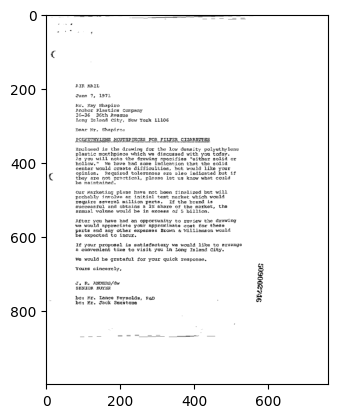

180
angle
0      16
180     4
Name: count, dtype: int64


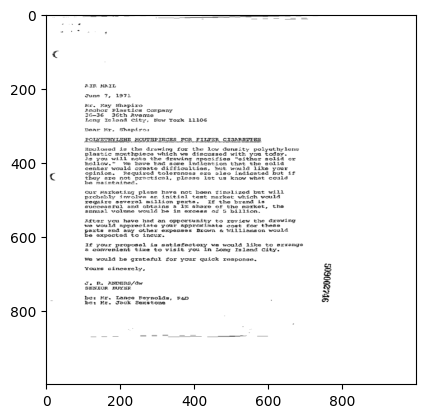

100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


AIR MAIL une 7, 1972  Nr. Kay Shapiro  Anchor Plastics company  36-36 36th Avenue  Leng Iclaad city, New York 11106 Dear Mr. Shapiro:  POIWETHYIENE MOUTHPIECES FOR PIETER CIGARETTES  Enclosed is the drewing for the low density polyethylens plastic mouthpiece which we discussed with you today As you will note the drawing specifies "either solid or hollow." We bave ha@ sore indication that the solia center would create difficulties, but would like your opinion. Required tolerances era aleo indicated but if they axe not practical, plesse let us know what could }@ maintained.  our Marketing plans have not been ¢inalized but will probably involve ar initial test market which would require several million perts. If the brand is successful and obtains 2 1% share of the merket, the anmial volume woulé be in excess of 5 billion.  A£ter you have had an opportunity to review the @rewing we would appreciate your approximate cost for these parts end any other expenses Brown « Williamson would be ex

100%|██████████| 20/20 [00:08<00:00,  2.28it/s]

air mail une kay shapiro anchor plastics company avenue leng iclaad city new york dear shapiro poiwethyiene mouthpieces pieter cigarettes enclosed drewing low density polyethylens plastic mouthpiece discussed today note drawing specifies solid hollow bave sore indication solia center create difficulties like opinion required tolerances era aleo indicated axe practical plesse let know maintained marketing plans inalized probably involve initial test market require million perts brand successful obtains share merket anmial volume woul excess billion ter opportunity review rewing appreciate approximate cost parts end expenses brown williamson expected incur proposal satisfactory like errange convenient time visit long island city grateful quick response sincerely anders senior buyse lance reynolds rsp jack sexstone


In [38]:
#Rotating and resizing the pictures

n = 1

#plot the first picture
plt.imshow(df['picture'][n], cmap='gray')
plt.show()

df['angle'] = df.picture.apply(get_text_orientation)
print(df['angle'][n])
print(df['angle'].value_counts())

df['picture'] = df.apply(lambda x: rotate_image(x['picture'], x['angle']), axis=1)
df['picture'] = df.apply(lambda x: resize_image(x['picture']), axis=1)

#plot the first picture
plt.imshow(df['picture'][n], cmap='gray')
plt.show()

#ocr with pytesseract
df['ocr_text'] = ocr_pytesseract(df.picture)
print(df['ocr_text'][n])

#cleaning the text
df['clean_text'] = clean_text(df.ocr_text)
print(df['clean_text'][n])